# AA Project

By Enric Millán and Juan Pablo Zaldivar

# 0. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
from pandas import read_csv
from scipy.stats import boxcox
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.genmod.generalized_linear_model import GLM

import warnings  
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Introduction

## 1.1 Problem Statement

League of Legends (también conocido como LoL) es un videojuego multijugador en línea de estrategia en tiempo real y de género MOBA (Multiplayer Online Battle Arena), en el cual dos equipos de cinco jugadores compiten para destruir la base del equipo contrario en un mapa simétrico. Cada jugador controla a un personaje, llamado campeón, que tiene habilidades únicas y distintas para luchar contra los enemigos y para ayudar a su equipo a ganar la partida. Los jugadores ganan experiencia y oro al derrotar a los enemigos y a los monstruos del mapa, lo que les permite mejorar sus habilidades y comprar objetos para fortalecer a sus campeones. 

League of Legends es uno de los videojuegos más populares y competitivos del mundo, con millones de jugadores en todo el mundo, por lo que hemos creído interesante estudiar datos de los **10 primeros minutos** de casi 10,000 partidas del rango Diamante (uno de los rangos usados para clasificar a los jugadores según su nivel) para intentar predecir el desenlace de estas partidas y analizar que factores tienen más importancia en los 10 primeros minutos a la hora de que uno de los dos equipos gane la partida.

Los datos en formato *csv* han sido extraídos de [*Kaggle*](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min?resource=download), pero han sido distribuídos originalmente por *Riot Games* (empresa creadora de League of Legends).

## 1.2 Objective

# 2. Data

In [11]:
# Load the data
dataset = read_csv("league_dataset.csv", header=0, delimiter=',')
dataset.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## 2.1 Data Description

In [3]:
dataset.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,14.414111,-33.620306,21.669956,1650.345551,22.367952,2.723150,0.495192,6.137666,6.183925,6.662112,0.573135,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,2453.349179,1920.370438,2.185844,153.544664,18.457427,2.138356,0.500002,2.933818,3.011028,4.060612,0.626482,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.000000,-9333.000000,9.000000,1073.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,-1585.500000,-1290.500000,20.200000,1541.550000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,14.000000,-28.000000,21.800000,1639.800000,16.000000,2.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,1596.000000,1212.000000,23.200000,1745.900000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.000000,8348.000000,28.300000,2370.100000,276.000000,24.000000,1.000000,22.000000,22.000000,28.000000,2.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


A simple vista y aplicando conocimientos previos del juego hay algunos valores que parecen no encajar. Por ejemplo, para la variable *blueWardsPlaced* el valor máximo es de 250 (y para *redWardsPlaced* sucede algo similar con 276), valor que desentona ya que es un valor muy elevado incluso para partidas completas. La única manera de llegar a esta cantidad en los 10 primeros minutos de partida implica que alguno o varios de los jugadores, potencialmente el jugador con rol de *Support* o soporte ya que en este rol se suele adquirir un objeto que permite colocar más *Wards* de lo normal, esten jugando de forma errática con el propósito de alcanzar tal y cantidad y no con el propósito de ganar la partida. 

Otros dos valores que llaman la atención son los valores máximos de las diferencias de experiencia y oro (*blueGoldDiff*, *blueExperienceDiff* y sus contrapartes para el equipo rojo). Era de esperar que saliesen valores como estos ya que en partidas donde la diferencia de nivel es muy grande (cosa que debería pasar en pocos casos ya que las partidas se establecen con jugadores de rango similar) o como en el caso anterior, uno o varios jugadores de un equipo están jugando con otros objetivos diferentes de la victoria y estan dejando al equipo rival tomar ventaja. Estos casos se relacionan directamente con valores atípicamente bajos de oro y experiencia (*blueTotalGold* y *blueTotalExperience*) para ambos equipos como veremos más adelante.

Se volverán a analizar estos casos (si es necesario) en apartados posteriores ya que, como se ha argumentado, es muy probable que se trate de outilers. 

In [4]:
dataset.shape

(9879, 40)

Tras la lectura de los datos observamos que tenemos 9879 partidas, cada una de ellas con 40 columnas, las cuales representan las características de cada partida. La columna **blueWins** es la que nos indica si el equipo azul ha ganado la partida o no, por lo tanto será nuestra variable objetivo. 

La variable objetivo es una variable binaria, por lo que podemos calcular la proporción de partidas ganadas por el equipo azul y el equipo rojo para comprobar que nuestro dataset está equilibrado, es decir, que el porcentaje de victorias azules debería ser aproximadamente del 50%.

Red Wins: 4949 (50.096%), Blue Wins: 4930(49.904%)


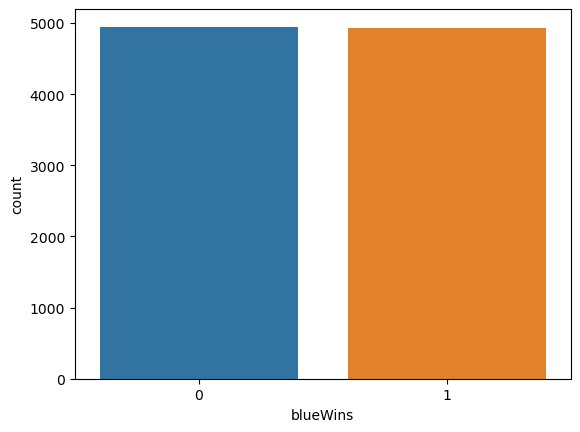

In [5]:
Bw = dataset.blueWins
W, L = Bw.value_counts()

# countplot of blueWins
sns.countplot(x='blueWins', data=dataset)
print('Red Wins: {} ({}%), Blue Wins: {}({}%)'.format(W,round(100*W/(W+L),3),L,round(100*L/(W+L),3)))

Como se observa, los datos sobre la variable objetivo están correctamente equilibrados.

## 2.2 Variable Description

Con respecto a las variables predictoras, podemos observar que tenemos 37 variables numéricas y 3 variables categóricas (existen otras variables que toman valores en un conjunto discreto y finito, pero de momento no consideramos que resulte útil tratarlas como categóricas).

In [6]:
dataset.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

Las variables categoricas son **blueFirstBlood**, **blueDragons** y **blueHeralds** (y sus contrapartes del equipo rojo). La primera variable indica si el equipo azul ha conseguido la primera sangre o no, mientras que la segunda y tercera indican si el equipo azul ha conseguido matar al dragon y al heraldo respectivamente. En cuanto a los valores que toman estas variables, podemos observar que las tres variables toman valores binarios.

Para los usuarios que no hayan jugado jamás al videojuego daremos una breve explicación de cada variable: 

- *blueWins* : esta variable indica si el equipo azul se ha alzado vencedor de la partida, es la variable que se quiere predecir (1 para victoria azul, 0 para victoria roja).

- *blueWardsPlaced* : indica el número de *wards* colocados por el equipo azul. Un *ward* aporta visión del mapa al equipo que lo coloca, por lo que puede suponer una ventaja táctica si se coloca apropiadamente.

- *blueWardsDestroyed* : indica el número de *wards* rojos destruidos por el equipo azul.

- *blueFirstBlood* : indica el equipo que ha hecho la primera sangre (primera *kill* o eliminación), 1 si ha sido el equipo azul, 0 si ha sido el equipo rojo.

- *blueKills* : indica el número total de *kills* o eliminaciones del equipo azul. Una *kill* se da cuando se elimina a uno de los jugadores rivales (tras ser eliminado se reaparece tras un cierto período de tiempo, por lo que no hay un límite de asesinatos).

- *blueAssists* : indica el número total de asistencias del equipo azul. Una asistencia se consigue cuando un jugador hace daño a un rival y en un corto periodo de tiempo ese rival es eliminado por otro jugador distinto (este consigue una *kill*).

- *blueDragons* : indica la cantidad de *Dragones* eliminados por el quipo azul. En los 10 primeros minutos solo es posible eliminar 1 como mucho.

- *blueHeralds* : indica la cantidad de *Heraldos* eliminados por el equipo azul. Tal y como sucede con los dragones, en los 10 primeros minutos solo es posible eliminar 1 como mucho.

- *blueTowersDestroyed* : indica el número de *torres* del equipo rojo (principales estructuras defensivas) destruídas por el equipo azul.

- *blueTotalGold* : indica el número total de oro conseguido por los integrantes del equipo azul. El oro permite comprar objetos que aportan ventajas y mejoran las estadísticas del jugador.

- *blueAvgLevel* : indica la media de nivel de los jugadores del equipo azul tras los 10 primeros minutos. Cada jugador sube de nivel con la *experiencia*, que se consigue eliminando *súbditos*, *monstruos* y jugadores enemigos entre otros.

- *blueTotalExperience* : indica la cantidad de experiencia total conseguida por el equipo azul. La experiencia permite subir de nivel al jugador y mejorar así sus habilidades y ataques.

- *blueTotalMinionsKilled* : indica la cantidad total de *minions* o *súbditos* eliminados por el equipo azul durante los 10 primeros minutos. Eliminar súbditos aporta tanto experiencia como oro.

- *blueTotalJungleMinionsKilled* : indica la cantidad de monstruos de la jungla eliminados por el equipo azul. Los monstruos de la jungla tienen una función similar a la de los súbditos, pero estos aportan más oro y experiencia al jugador del equipo con el rol de *jungla*.

Existen las variables que relacionan algunas de las ya explicadas (como, por ejemplo,*blueGoldDiff*), que en apartados posteriores serán explicadas para justificar su posible eliminación del dataset, y también están estas mismas variables para el equipo rojo.

#### 2.2.1 Glossary


- *Ward* : ítem que puede colocarse en el mapa para revelar una zona y aportar visión a tu equipo. Resulta muy útil a nivel táctico para controlar objetivos como Dragones o Heraldos.

- *Minion* o *Súbdito* : NPC (Non Playable Character) que pertenece a un equipo (aparecen la misma cantidad de súbditos para el equipo rojo y para el equipo azul). Cuando mueren aportan experiencia a los jugadores del equipo contrario cercanos, y oro exclusivamente al jugador enemigo que haya eliminado al súbidto.

- *Jungle Minion* o *Monstruo de la Jungla* : NPC que no pertenece a ningun equipo. Aporta oro y experiencia de la misma manera que los súbditos normales al ser eliminado, pero este oro y experiencia aumenta si el jugador que los elimina es que tiene el rol de *Jungla*. Según de que monstruo se trate también puede aportar potenciadores temporales al jugador que lo haya eliminado.

- *Dragones* : calificados como *Monstruos Épicos* aparecen en una zona concreta cada cierto tiempo (como se ha mencionado, en los primeros 10 minutos solo es posible eliminar a uno) del mapa y tiene mucha más vitalidad que los demás monstruos de la Jungla. Al ser eliminado por un equipo, además de aportar oro y experiencia a todos los miembros del equipo también les aporta un potenciador permanente que dura toda la partida y cuyos efectos varían según el tipo de dragón.

- *Heraldos* : también calificados como *Monstruos Épicos*, aparece en otra zona concreta del mapa cada cierto tiempo (solo es posible elimianr 1 durante los primeros 10 minutos) y aporta oro y experiencia al equipo que lo elimine, pero su principal utilidad es que tras ser eliminado el jugador que recoja su *ojo* podrá invocar al Herlado que actuará como un súbdito de gran tamaño y vida y que  si impacta contra estructuras enemigas (torres) causará un gran daño a estas.

- *Torres* : para ganar la partida se debe destruir el *Nexo* enemigo, y las torres son las estructuras defensivas que deben ser destruidas para poder llegar al *Nexo*. Destruir torres además de una ventaja táctica también aporta una gran cantidad de oro.

- *Nivel* : el nivel determina junto a los objetos el "poder" de un jugador. Todos los jugadores empiezan en nivel 1 al inicio de la partida y el nivel máximo es 18. Se sube de nivel con la experiencia conseguida por derrotar súbditos, jugadores rivales, etc.



# 3. Data Preprocessing

## 3.1 Data Cleaning

### 3.1.1 Drop Columns

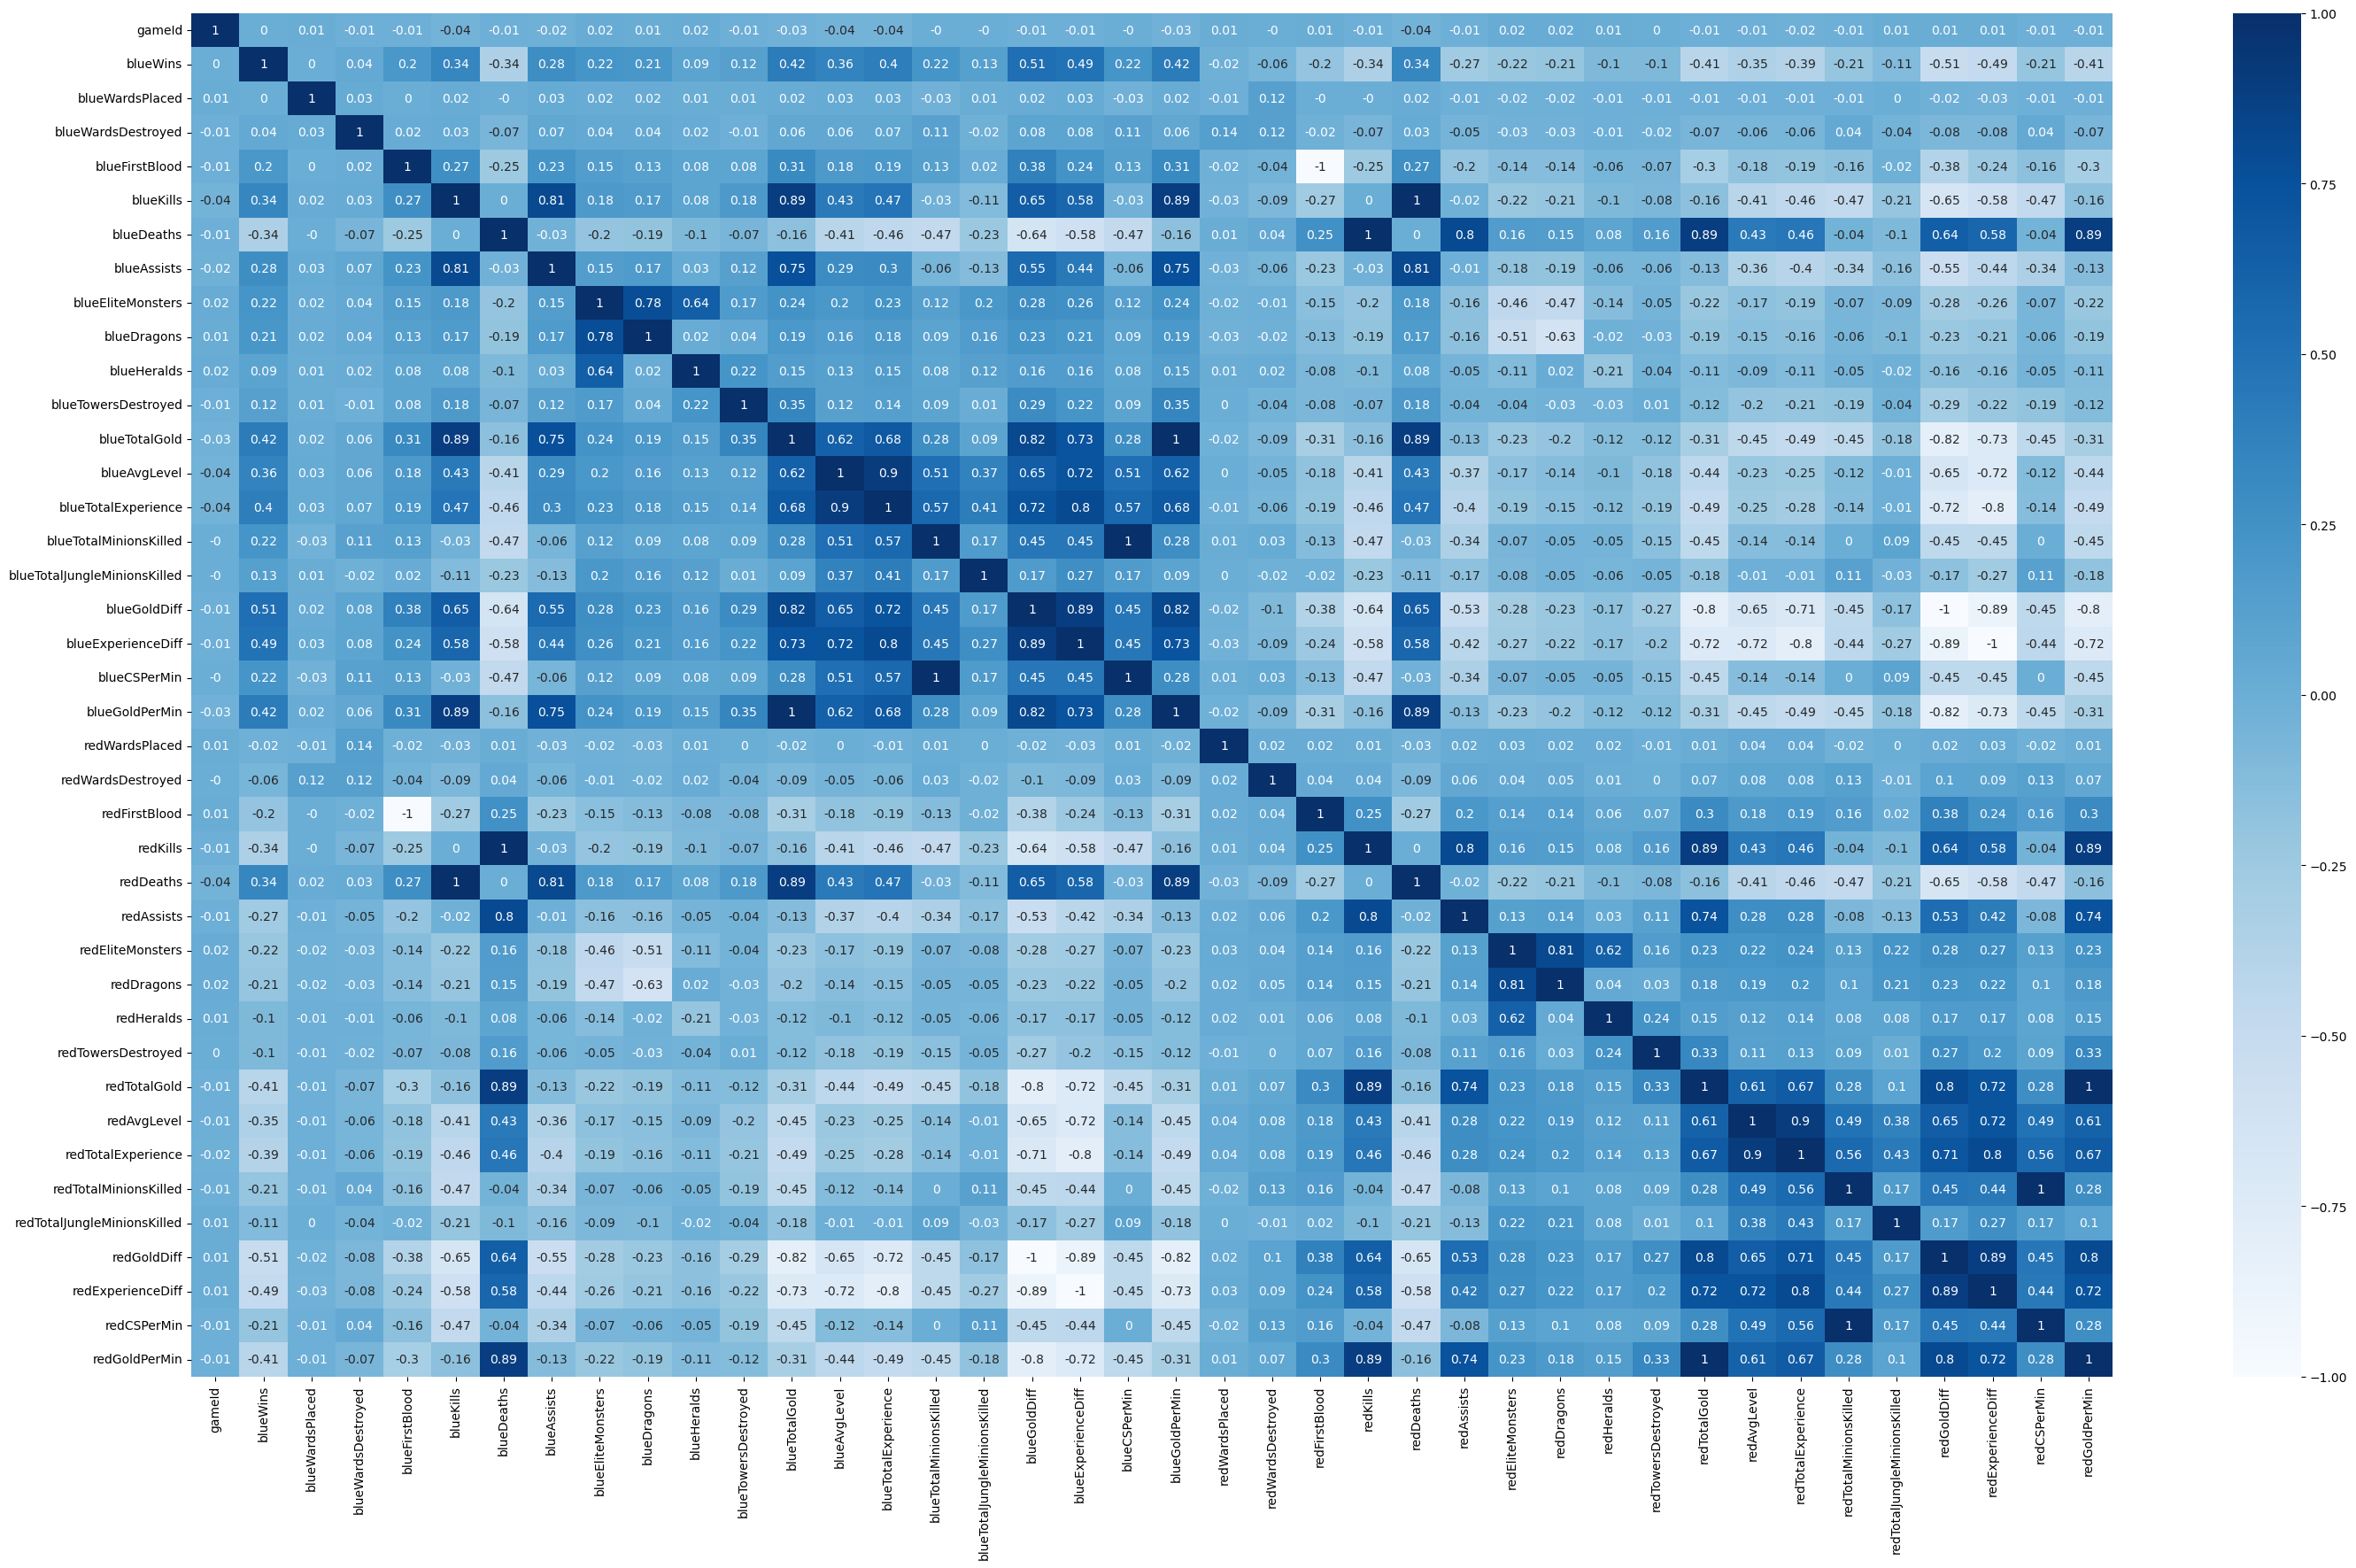

In [4]:
plt.figure(figsize=(35,20))
sns.heatmap(round(dataset.corr(),2), cmap='Blues', annot=True)
plt.show()


Tras la descripción de las variables y el plot del *heatmap* podemos observar que hay correlación entre distintas variables. Teniendo en cuenta esto y los conocimientos previos sobre el videojuego, en este apartado trataremos estos casos y eliminaremos las variables que no resulten útiles o sean redundantes a simple vista:

- *gameId* : esta variable actua como identificador de cada partida, algo que no tiene influencia sobre la propia partida.

- *redCSPerMin* : esta variable es completamente dependiente de *redTotalMinionsKilled*, pues su valor es el esta ultima variable dividido entre 10 (minutos de partida transcurridos en el momento en el que se toman los datos).

- *blueCSPerMin* : mismo caso que con *redCSPerMin*.

- *redGoldPerMin* y *blueGoldPerMin*: exactamente la misma situación que con las dos variables anteriores, sus valores son los de *redTotalGold* y *blueTotalGold* divididos entre 10 (minutos de partida transcurridos en el momento en el que se toman los datos).

- *redGoldDiff* : como estamos prediciendo si gana el equipo azul mantendremos *blueGoldDiff* (que tiene el mismo valor que *redGoldDiff* pero con signo contrario) ya que por el momento nos parece interesante emfatizar la importancia de la diferencia de este recurso en el juego.

- *redEliteMonsters* y *blueEliteMonsters* : estas variables son la suma de *redDragons* y *redHeralds*, y *blueDragons* y *blueHeralds* respectivamente, por lo que también son variables redundantes.

- *redExperienceDiff* : tal y como pasa con las variables que representan la diferencia de oro, estas representan la diferencia de experiencia por lo que son directamente dependientes de *redTotalExperience* y *blueTotalExperience*. Como en el caso anterior, mantendremos *blueExperienceDiff* para emfatizar la diferencia entre ambos equipos.

- *redDeaths* y *blueDeaths* : variables directamente ligadas a *blueKills* y *redKills*, por lo que son redundantes.

- *redFirstBlood* : variable directamente ligada a *blueFirstBlood*, si esta última toma valor 1 el equipo azul ha hecho la primera sangre, si toma valor 0 el equipo rojo ha hecho la primera sangre. Podría darse el caso de que ninguno de los dos equipos haga la primera sangre, pero esto no es posible en el dataset, pues si ninguno de los dos equipos ha hecho la primera sangre, ambas variables toman valor 0 y como se comprueba a continuación, no hay ninguna partida en la que esto ocurra.

- *blueWardsDestroyed* y *redWardsDestroyed* : si bien colocar *wards* aporta visión sobre algunas zonas del mapa, eliminarlos o destruirlos lleva más tiempo (puesto que según el tipo debe ser golpeado hasta 4 veces y colocarlo es instantáneo) y tiene una influencia considerablemente menor que colocarlos.

In [8]:
len(dataset[(dataset['blueFirstBlood'] == 0) & (dataset['redFirstBlood'] == 0)])

0

Procedemos a limpiar el dataset:

In [12]:
drop_cols = ['gameId','blueCSPerMin','blueGoldPerMin','blueDeaths','blueEliteMonsters', 'blueWardsDestroyed', 'redWardsDestroyed',
             'redDeaths','redCSPerMin','redGoldDiff','redFirstBlood','redGoldPerMin','redEliteMonsters','redExperienceDiff']
dataset.drop(drop_cols, axis=1, inplace=True)
dataset.head(10)

,blueWins,blueWardsPlaced,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redKills,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,1,9,11,0,0,0,17210,6.6,17039,195,36,643,-8,15,6,8,0,0,0,16567,6.8,17047,197,55
1,0,12,0,5,5,0,0,0,14712,6.6,16265,174,43,-2908,-1173,12,5,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,7,4,1,0,0,16113,6.4,16221,186,46,-1172,-1033,15,11,14,0,0,0,17285,6.8,17254,203,28
3,0,43,0,4,5,0,1,0,15157,7.0,17954,201,55,-1321,-7,15,5,10,0,0,0,16478,7.0,17961,235,47
4,0,75,0,6,6,0,0,0,16400,7.0,18543,210,57,-1004,230,17,6,7,1,0,0,17404,7.0,18313,225,67
5,1,18,0,5,6,1,0,0,15899,7.0,18161,225,42,698,101,36,3,2,0,0,0,15201,7.0,18060,221,59
6,1,18,1,7,7,1,0,0,16874,6.8,16967,225,53,2411,1563,57,6,9,0,0,0,14463,6.4,15404,164,35
7,0,16,0,5,3,0,0,0,15305,6.4,16138,209,48,-2615,-800,15,13,11,1,0,0,17920,6.6,16938,157,54
8,0,16,0,7,8,0,0,0,16401,7.2,18527,189,61,-1979,-771,15,7,5,1,1,0,18380,7.2,19298,240,53
9,1,13,1,4,5,1,0,0,15057,6.8,16805,220,39,-1548,-1574,16,5,4,0,0,0,16605,6.8,18379,247,43


### 3.1.2 Missing Values

Tras haber hecho una primera limpieza del dataset, y a pesar de que en *Kaggle* se indica que el dataset no tiene *Missing Values* ya que son datos empíricos que se recolectan en todas la partidas por la propia empresa desarrolladora (*Riot Games*) y de los que no hay posibilidad de que "no existan", haremos una breves comprobaciones para confirmar este hecho.

In [6]:
dataset.isnull().sum().sum()

0

Como podemos observar en la tabla anterior, no tenemos ningún valor nulo en nuestro dataset, por lo que no será necesario realizar ningún tratamiento de valores nulos.

In [7]:
dataset.isna().sum().sum()

0

Tampoco existen valores *Na* que puedan afectar a los futuros modelos.

In [9]:
print(dataset[dataset.eq("-").any(1)].count().sum(),
      dataset[dataset.eq("#").any(1)].count().sum(),
      dataset[dataset.eq("?").any(1)].count().sum(),
      dataset[dataset.eq(" ").any(1)].count().sum(),
      ) 

0 0 0 0


Probando con otras posibles configuraciones para *Missing Values* confirmamos nuestra suposición.

### 3.1.3 Outlier treatment

Con el análisis inicial ya nos hemos hehco una idea de donde podría haber outliers o observaciones atípicas. Para dar un contetxo más visual y poder detectar posibles outliers en otras variables haremos un *boxplot* de estas. No se tiene en cuenta variables como *blueTotalMinionsKilled* y *blueTotalJungleMinionsKilled* entre otras varias ya que son variables que si que pueden fluctuar más sin tener necesariamente un sentido negativo que no se pueda identificar ya con otras variables; por ejemplo, si hay jugadores del equipo azul inactivos en la partida y *blueTotalMinionsKilled* es muy reducida, este efecto se verá reflejado también en la diferencia de oro entre ambos equipos, ya que los *minions* o súbditos son una de las fuentes principales de oro. Otros casos que no se tendrán en cuenta son  variables como *blueAssists* ya que dependen más del estilo de juego de cada equipo (si un equipo juega muy junto y todos los jugadores participan en las peleas de forma conjunta, por cada *kill* que hagan es muy probable que surjan 3 o 4 asistencias que inflen este conatdor) que puede ser muy variado según la partida y más teniendo en cuenta que los juagdores no pueden comunicarse más allá de con un chat de texto y algunas indicaciones audiovisuales que ofrece el propio juego.

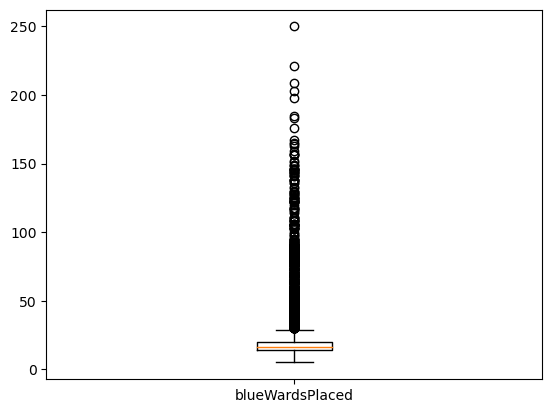

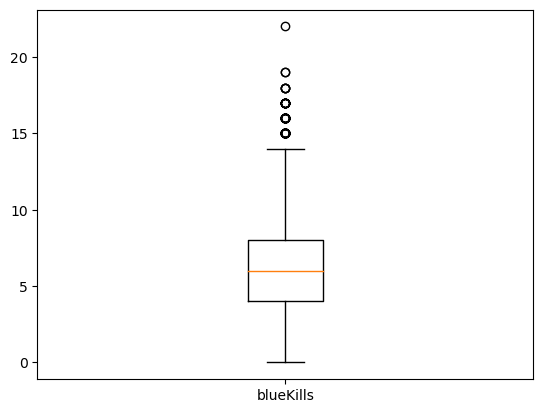

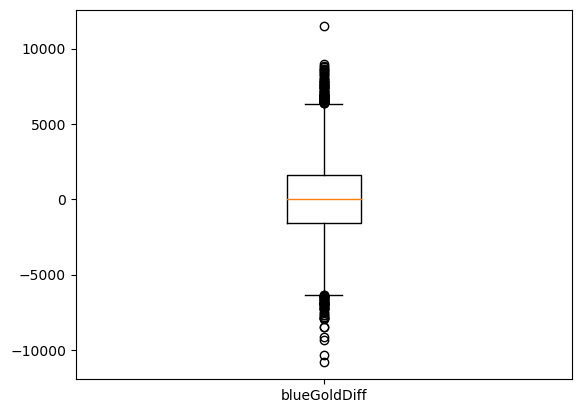

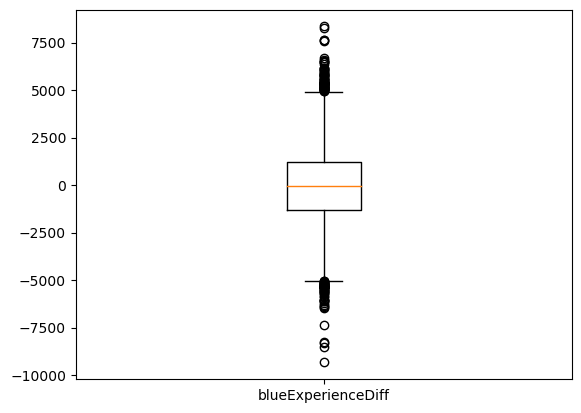

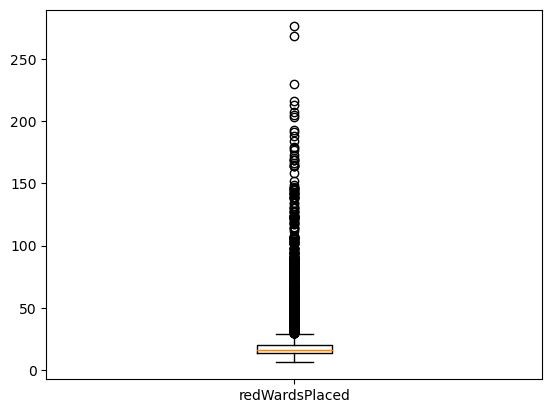

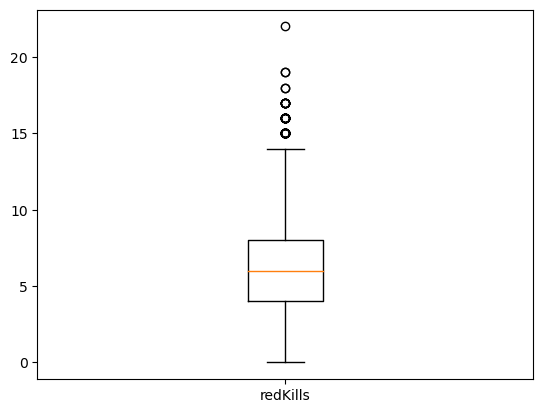

In [21]:
columns=['blueWardsPlaced','blueKills', 'blueGoldDiff', 'blueExperienceDiff', 'redWardsPlaced','redKills',]

for column in columns:
    plt.boxplot(dataset[column], labels=[column])
    plt.show()


Para descartar los posibles outliers usaremos principalmente la distancia entre cuartiles, definiendo concretamente los outliers de la siguiente manera:

- Los valores más pequeños que Q1-1.5*IQR

- Los valores más grandes que Q3+1.5*IQR

In [34]:
Q1 = dataset['blueGoldDiff'].quantile(0.25)
Q3 = dataset['blueGoldDiff'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['blueGoldDiff'] < (Q1 - 1.5 * IQR)
big_outliers = dataset['blueGoldDiff'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(50, 77, 3181.5)

Con este métodod detectamos 127 outliers para la variable *blueGoldDiff*, es decir, una cantidad que representa aproximadamente un 1% del dataset, por lo que no supone un problema elimnarla de este mismo.

In [35]:
dataset = dataset[~(small_outliers | big_outliers)]

In [36]:
Q1 = dataset['blueExperienceDiff'].quantile(0.25)
Q3 = dataset['blueExperienceDiff'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['blueExperienceDiff'] < (Q1 - 1.5 * IQR)
big_outliers = dataset['blueExperienceDiff'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(32, 34)

Para *blueExperienceDiff* hay un total de 66 outliers, que también eliminaremos ya que no representan ni un 1% del dataset resultante.

In [37]:
dataset = dataset[~(small_outliers | big_outliers)]

In [38]:
Q1 = dataset['blueKills'].quantile(0.25)
Q3 = dataset['blueKills'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['blueKills'] < (Q1 - 1.5 * IQR)
big_outliers = dataset['blueKills'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 57)

Con *blueKills* se detectan 57, cantidad de la que, una vez más, podemos prescindir para poder modelar sin tener en cuenta observaciones atípicas.

In [39]:
dataset = dataset[~(small_outliers | big_outliers)]

In [40]:
Q1 = dataset['redKills'].quantile(0.25)
Q3 = dataset['redKills'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['redKills'] < (Q1 - 1.5 * IQR)
big_outliers = dataset['redKills'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 51)

Con *redKills* obtenemos 51, una cantidad similar a la anterior y de la que también prescindiremos.

In [41]:
dataset = dataset[~(small_outliers | big_outliers)]

In [47]:
Q1 = dataset['blueWardsPlaced'].quantile(0.25)
Q3 = dataset['blueWardsPlaced'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['blueWardsPlaced'] < (Q1 - 1.5 * IQR)
big_outliers = dataset['blueWardsPlaced'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 1581)

Usando este método se detectan 1581 posibles outliers para la variable *blueWardsPlaced*, que es una cantidad que representa más del 10% del dataset, por lo que para este caso ajustaremos el criterio para que sea menos estricto. Como el IQR para esta variable toma el valor de 6, daremos un margen de 10 veces lo usual, que en este caso equivaldria a 60  (6x15), ya que en una partida se pueden dar momentos de más tensión como la disputa por un Dragón o Heraldo en el que los juagdores coloquen más *wards* de lo normal con tal de poder hacerse con tal objetivo, o simplemente, puede suceder que estilo de juego de algunos jugadores se base mucho en la visión del equipo sobre el mapa y por tanto tengan tendencia a colocar más *wards* de lo que se considera normal. Estos últimos casos, a pesar de que no muy comunes, son totalmente posibles y válidos y no influyen significativemnte sobre el desenlace de la partida, es por esto que con esta variable buscamos ser más permisivos.

In [48]:
Q1 = dataset['blueWardsPlaced'].quantile(0.25)
Q3 = dataset['blueWardsPlaced'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['blueWardsPlaced'] < (Q1 - 15 * IQR)
big_outliers = dataset['blueWardsPlaced'] > (Q3 + 15 * IQR)

sum(small_outliers), sum(big_outliers),

(0, 78)

Con este criterio mucho menos estricto obtenemos 78 outliers, que representan nuevamente una cantidad muy reducida del dataset, lo que nos permite poder prescindir de ellos.

In [49]:
dataset = dataset[~(small_outliers | big_outliers)]

Con *redWardsPlaced* se seguirá el mismo procedimiento:

In [51]:
Q1 = dataset['redWardsPlaced'].quantile(0.25)
Q3 = dataset['redWardsPlaced'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

small_outliers = dataset['redWardsPlaced'] < (Q1 - 15 * IQR)
big_outliers = dataset['redWardsPlaced'] > (Q3 + 15 * IQR)

sum(small_outliers), sum(big_outliers),

(0, 84)

In [52]:
dataset = dataset[~(small_outliers | big_outliers)]

Por el momento procederemos eliminando estos outliers y analizaremos en futuros apartados si debemos replantear tales decisiones.

## 3.2 Data Transformation

### 3.2.1 Data Types treatment

In [22]:
categorical_columns = list(dataset.dtypes[dataset.dtypes == 'O'].index.values)
for column in categorical_columns:
    dataset[column] = dataset[column].astype('category')

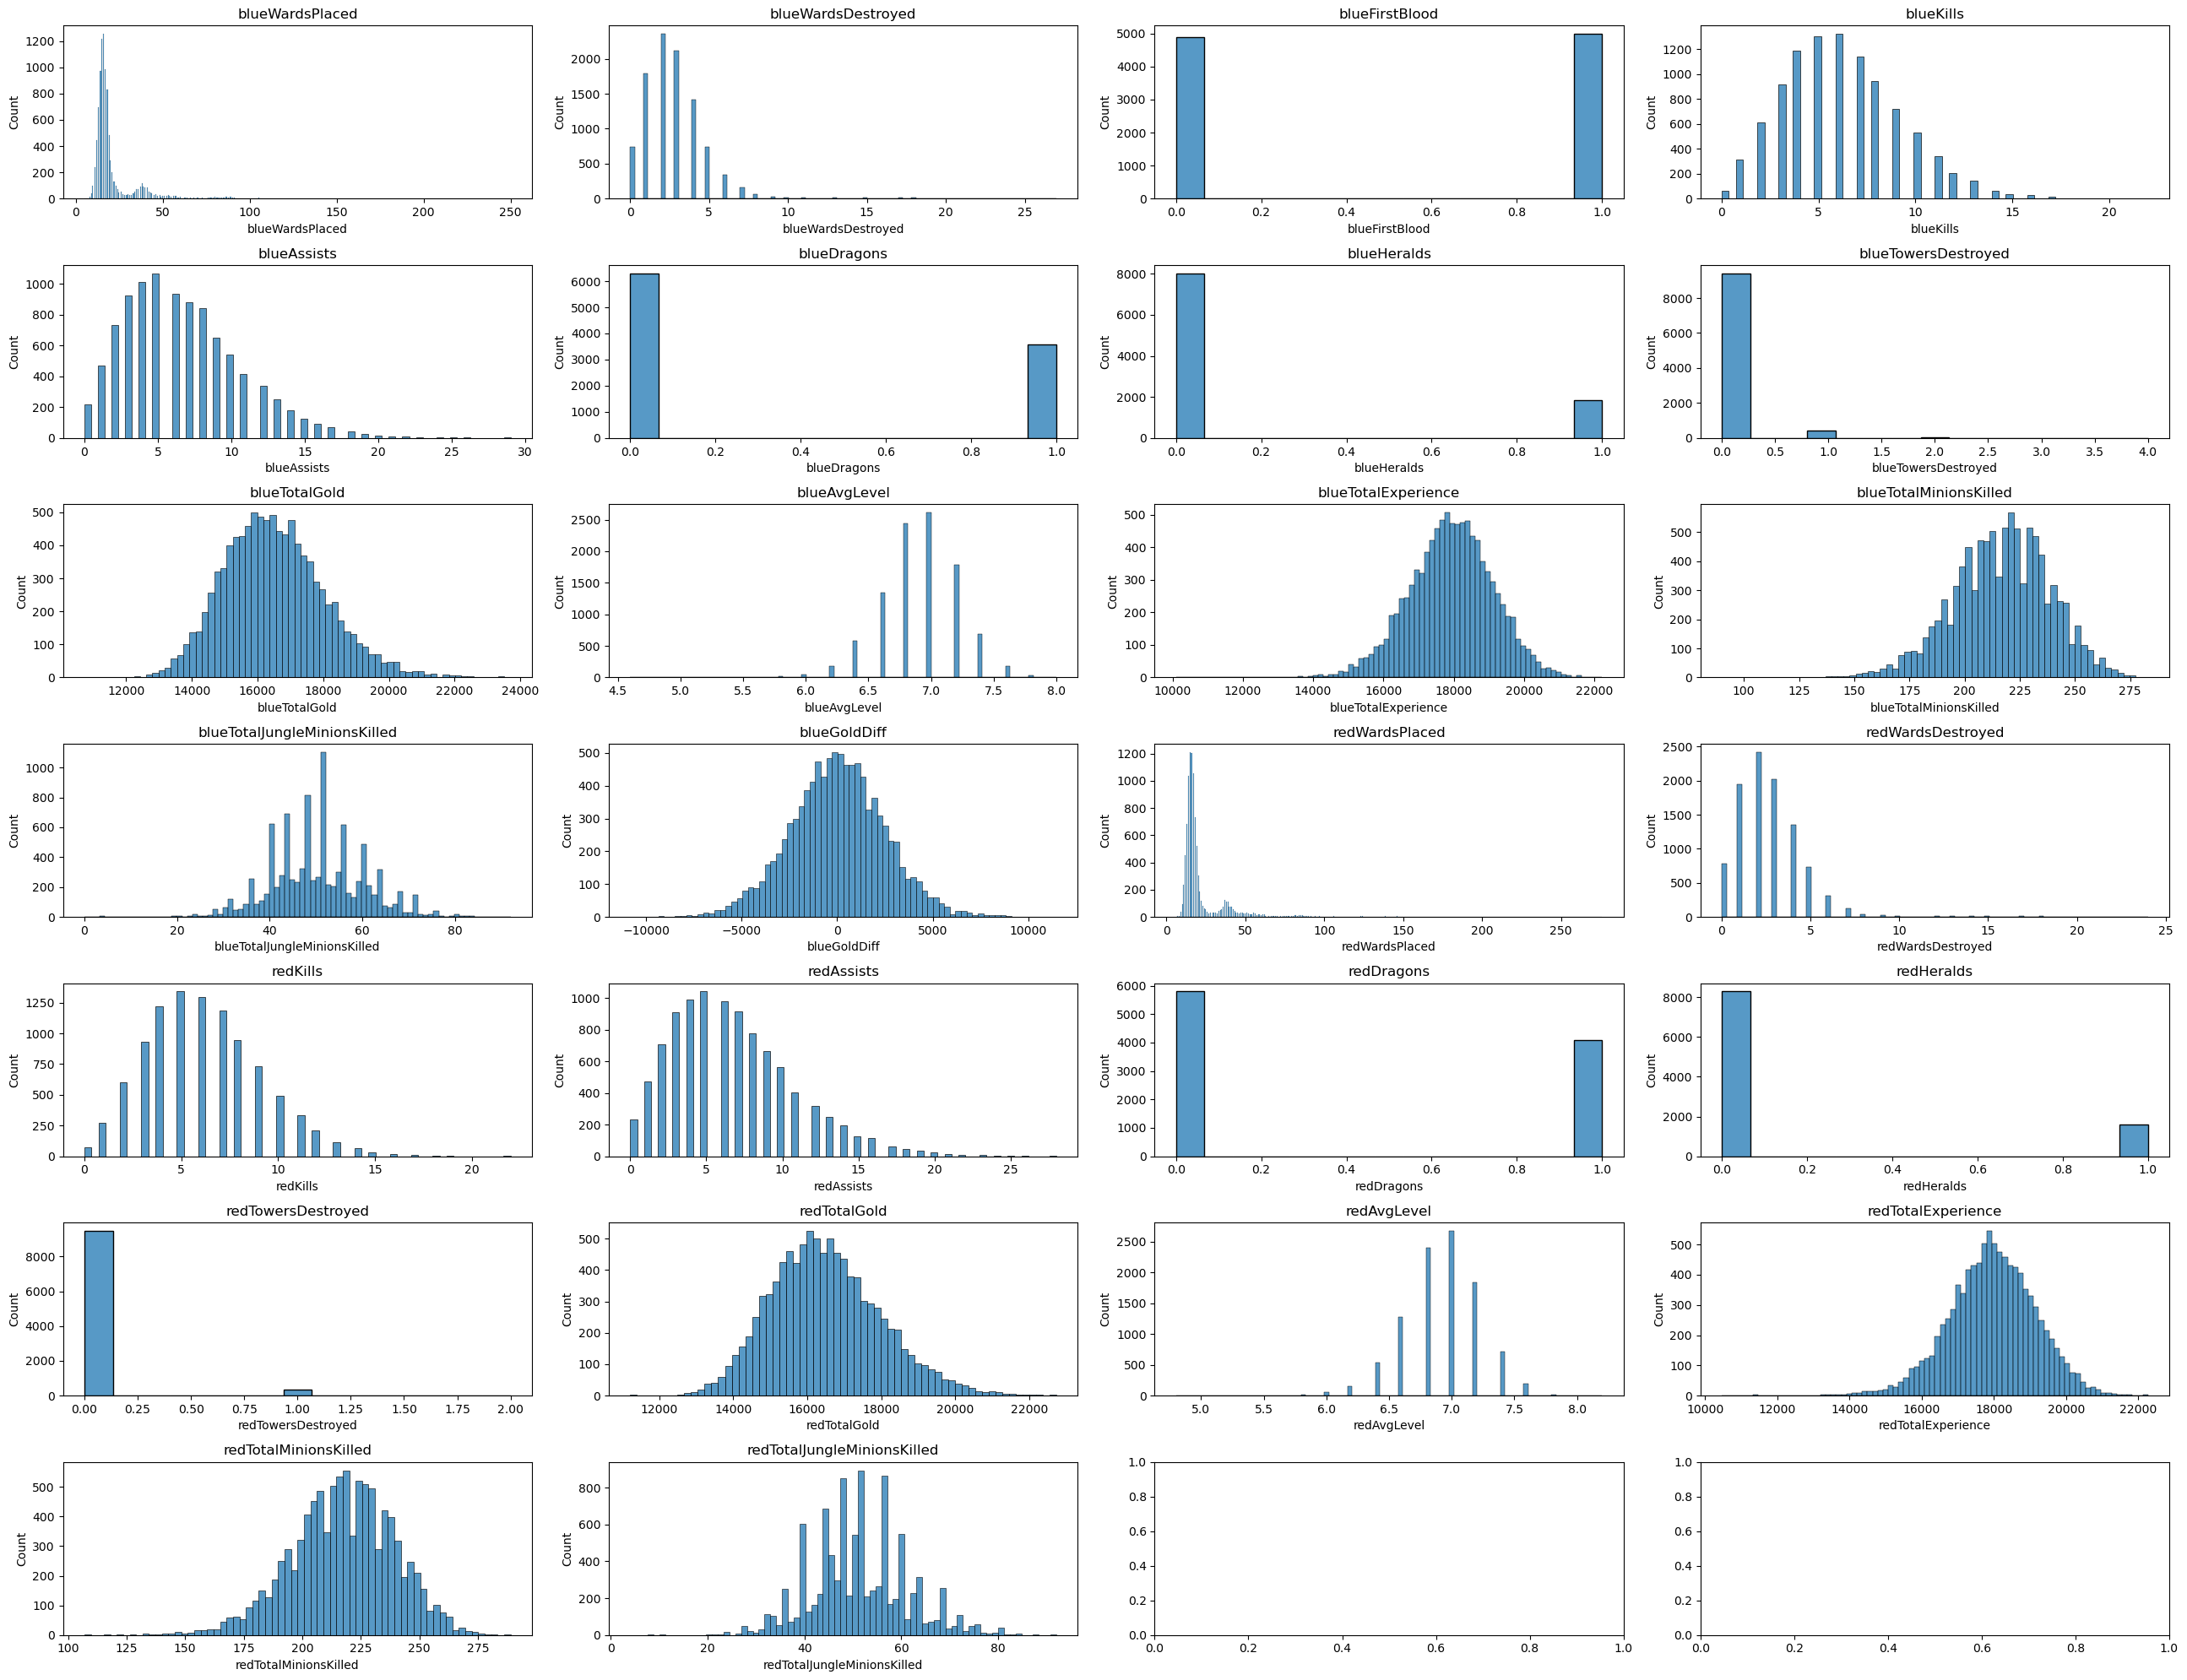

In [23]:
fig, axes = plt.subplots(7,4,figsize=(26,20))

for i, c in enumerate(dataset.columns[1:]):
    ax = axes.reshape(-1)[i]
    if dataset[c].dtype.kind == 'O': # If categorical
        a = sn.countplot(x=c,data=dataset,ax=ax, color='green')
    else: # If numerical
        b = sn.histplot(x=c,data=dataset,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

### 3.2.2 Encoding


### 3.2.3 Standardization

### 3.2.4 Normalization

## 3.3 Data Visualization

# 4. Model Building

# 5. PRUEBAS

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [25]:
y = dtclean.blueWins
drop_cols = ['blueWins']
x = dtclean.drop(drop_cols, axis=1)
X = preprocessing.StandardScaler().fit(x).transform(x.astype(float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (6593, 26) (6593,)
Test set: (1649, 26) (1649,)


In [26]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Algorithm', 'Accuracy', 'Recall', 'Precision', 'F-Score']
def get_confusion_matrix(algorithm, y_pred, y_actual):
    # Create confusion matrix and interpret values
    con = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = con[0][0], con[0][1], con[1][0], con[1][1]
    algorithm = algorithm
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f_score = (2 * precision * recall) / (recall + precision)
    return algorithm, accuracy, recall, precision, f_score